In [152]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score


In [153]:
mls25_def = pd.read_csv('/Users/amitmishra/fbref-analytics/data/mls2025_defense_cleaned.csv')
mls25_shots = pd.read_csv('/Users/amitmishra/fbref-analytics/data/mls2025_shooting_cleaned.csv')
mls25_gca = pd.read_csv('/Users/amitmishra/fbref-analytics/data/mls2025_gca_cleaned.csv')
mls25_std = pd.read_csv('/Users/amitmishra/fbref-analytics/data/mls2025_standard_cleaned.csv')

In [154]:
mls25_def.columns

Index(['Squad', 'Players_used', '90s', 'Tkl_attempted', 'TklW', 'Tkl_Def',
       'Tkl_Mid', 'Tkl_Att', 'Drib_Tkl', 'Drib_chal', 'Drib_Tkl%', 'Chal_Lost',
       'Blocks', 'Shots_blocked', 'Pass_blocked', 'Interceptions', 'Tkl+Int',
       'Clr', 'Err_shot'],
      dtype='object')

In [155]:
std_stats = ['Squad', 'Poss', 'npxG', 'xAG']
def_stats = ['Squad', 'Tkl_Att', 'Tkl_Mid']
gca_stats = ['Squad', 'GCA_PassLive','SCA']


In [156]:
df = mls25_std[std_stats]

In [157]:
merged_df = df.merge(mls25_def[def_stats], on = 'Squad', how = 'left')

In [158]:
merged_df = merged_df.merge(mls25_gca[gca_stats], on = 'Squad', how = 'left')

In [159]:
merged_df.head()

,Squad,Poss,npxG,xAG,Tkl_Att,Tkl_Mid,GCA_PassLive,SCA
0,Atlanta Utd,52.6,12.1,9.9,12,59,12,217
1,Austin,43.9,11.2,8.1,13,34,7,200
2,CF Montréal,54.1,9.8,7.2,22,72,3,167
3,Charlotte,47.6,11.1,8.7,14,47,10,161
4,Chicago Fire,48.7,13.6,10.4,21,42,17,194


In [160]:
# Perform aggregation by club, calculating means for numerical columns
agg_df = merged_df.groupby('Squad').mean()

In [161]:
#handle missing values by using imputer
imputer = SimpleImputer(strategy = 'mean')
imputed_df = imputer.fit_transform(agg_df)

In [162]:
agg_df.isna().sum()

Poss            0
npxG            0
xAG             0
Tkl_Att         0
Tkl_Mid         0
GCA_PassLive    0
SCA             0
dtype: int64

In [163]:
#Standardize the data

scaler = StandardScaler()
scaled_df = scaler.fit_transform(agg_df)

In [164]:
scaled_df = pd.DataFrame(scaled_df)
scaled_df.head()

,0,1,2,3,4,5,6
0,0.570609,0.221524,0.422631,-1.461199,0.281781,-0.326376,0.635682
1,-1.338737,-0.096622,-0.358947,-1.291293,-1.874709,-1.185259,0.160319
2,0.899807,-0.591516,-0.749736,0.237870,1.403157,-1.872366,-0.762446
3,-0.526716,-0.131972,-0.098421,-1.121386,-0.753334,-0.669929,-0.930221
4,-0.285305,0.751767,0.639736,0.067963,-1.184632,0.532508,-0.007457


### Apply KMeans clustering

In [165]:
num_clusters = 3
kmeans = KMeans(n_clusters = num_clusters)
cluster_labels = kmeans.fit_predict(scaled_df)

In [166]:
#add the cluster labels back to the aggregated dataframe
agg_df['cluster'] = cluster_labels

In [167]:
agg_df.head()

,Poss,npxG,xAG,Tkl_Att,Tkl_Mid,GCA_PassLive,SCA,cluster
Squad,,,,,,,,
Atlanta Utd,52.6,12.1,9.9,12.0,59.0,12.0,217.0,1
Austin,43.9,11.2,8.1,13.0,34.0,7.0,200.0,1
CF Montréal,54.1,9.8,7.2,22.0,72.0,3.0,167.0,2
Charlotte,47.6,11.1,8.7,14.0,47.0,10.0,161.0,1
Chicago Fire,48.7,13.6,10.4,21.0,42.0,17.0,194.0,1


In [168]:
#Finding optimum clusters

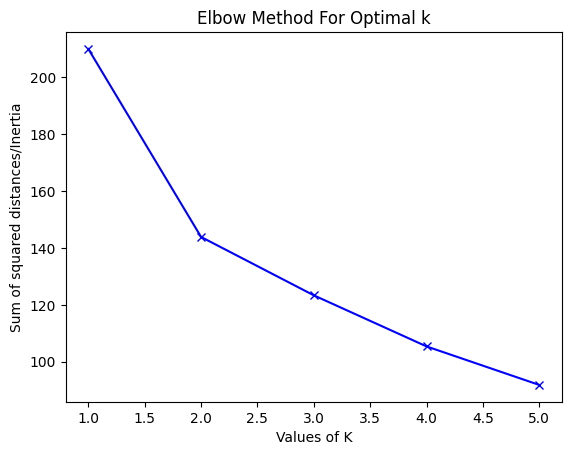

In [169]:
sum_sd = []
k = range(1,6)
for num_clusters in k:
    kmeans = KMeans(n_clusters = num_clusters)
    kmeans.fit(scaled_df)
    sum_sd.append(kmeans.inertia_)
plt.plot(k,sum_sd,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")
plt.show()

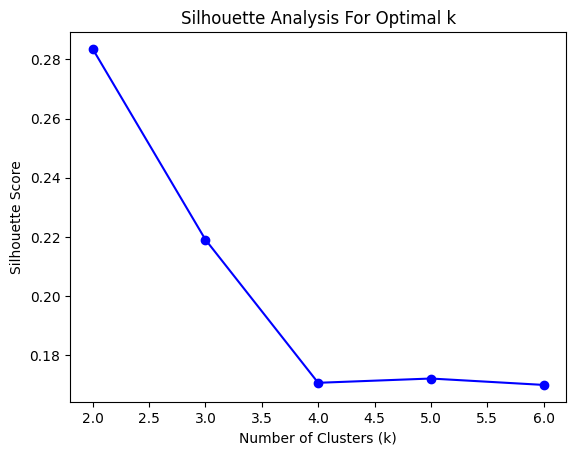

In [170]:
silhouette_scores = []
for k in range(2, 7):  # Silhouette score isn't defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_df)
    silhouette_scores.append(silhouette_score(scaled_df, cluster_labels))
    
plt.plot(range(2, 7), silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.show()

## K = 2: This might represent a fundamental division like possession-oriented vs. counter-attacking teams, or offensive vs. defensive-minded approaches.

## K = 3: Also performs relatively well, indicating there might be four meaningful tactical archetypes among MLS teams.

In [171]:
agg_df[agg_df['cluster'] == 0]

,Poss,npxG,xAG,Tkl_Att,Tkl_Mid,GCA_PassLive,SCA,cluster
Squad,,,,,,,,
Columbus Crew,57.9,13.6,10.8,21.0,52.0,17.0,196.0,0
Orlando City,46.1,13.5,11.1,20.0,49.0,20.0,227.0,0
Philadelphia Union,49.2,14.7,12.3,25.0,78.0,23.0,240.0,0
SJ Earthquakes,50.2,18.4,14.3,21.0,69.0,26.0,284.0,0
San Diego FC,58.2,14.4,11.3,25.0,46.0,20.0,212.0,0
Seattle Sounders,55.1,13.6,10.7,33.0,60.0,17.0,252.0,0
Vancouver W'caps,54.9,16.6,12.3,30.0,58.0,25.0,254.0,0


In [172]:
agg_df[agg_df['cluster'] == 1]

,Poss,npxG,xAG,Tkl_Att,Tkl_Mid,GCA_PassLive,SCA,cluster
Squad,,,,,,,,
Atlanta Utd,52.6,12.1,9.9,12.0,59.0,12.0,217.0,1
Austin,43.9,11.2,8.1,13.0,34.0,7.0,200.0,1
Charlotte,47.6,11.1,8.7,14.0,47.0,10.0,161.0,1
Chicago Fire,48.7,13.6,10.4,21.0,42.0,17.0,194.0,1
Colorado Rapids,44.0,11.6,9.6,20.0,56.0,20.0,179.0,1
D.C. United,50.8,11.5,9.1,28.0,59.0,14.0,197.0,1
FC Cincinnati,50.2,10.3,7.8,22.0,57.0,14.0,211.0,1
FC Dallas,46.8,10.2,8.1,26.0,47.0,11.0,157.0,1
Houston Dynamo,52.8,8.2,6.7,14.0,48.0,8.0,164.0,1


In [173]:
agg_df[agg_df['cluster'] == 2]

,Poss,npxG,xAG,Tkl_Att,Tkl_Mid,GCA_PassLive,SCA,cluster
Squad,,,,,,,,
CF Montréal,54.1,9.8,7.2,22.0,72.0,3.0,167.0,2
NE Revolution,46.9,5.9,4.7,17.0,59.0,6.0,152.0,2
NY Red Bulls,52.3,10.4,8.1,22.0,79.0,14.0,180.0,2
NYCFC,52.2,10.7,7.3,18.0,70.0,6.0,189.0,2
Sporting KC,53.0,8.0,6.5,29.0,70.0,19.0,163.0,2
Toronto FC,44.3,5.8,4.2,24.0,67.0,10.0,120.0,2


### High-powered attacking teams (Cluster 0): Teams that combine possession with effective chance creation
### Balanced/mixed-style teams (Cluster 1): Teams with varying approaches but moderate attacking output
### Defensively-oriented teams (Cluster 2): Teams that generate fewer quality chances